# United States Senator Ages in Python 
An analysis of the age of the US senate since 1781. 

 . |   |   |   |   |
- | - | - | - | - |
![Python](https://img.shields.io/badge/-Python-306998?style=for-the-badge&logo=Python&logoColor=white)|![Pandas](https://img.shields.io/badge/-pandas-150458?style=for-the-badge&logo=pandas&logoColor=white)|![BeautifulSoup](https://img.shields.io/badge/BeautifulSoup-black.svg?style=for-the-badge&logo=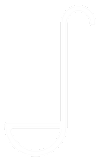)|![Seaborn](https://img.shields.io/badge/Seaborn-6478a6.svg?style=for-the-badge&logo=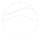)|![Requests](https://img.shields.io/badge/Requests-black.svg?style=for-the-badge&logo=)

In this exercise, we will use webscraping to pull the list of historical and current United States senators from Wikipedia.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
from bs4 import BeautifulSoup

## Historical list of United States senators 
We can pull the wikitable data off of Wikipedia and process that data to analyze the ages of each of the senators that have previously served in the Senate.

In [2]:
# URL from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_former_United_States_senators'

# Pull the data from the webpage
response = requests.get(url)

# Load the response into soup
soup = BeautifulSoup(response.text, 'html.parser')

# Find the wikitables
data=soup.find_all('table',{'class':"wikitable"})

# Replace any page breaks with commas for easier processing
df=pd.read_html(str(data).replace("<br/>", ","))

# Build the dataframe
df=pd.DataFrame(df[1])

# Clean the data
df = df[~df['Years'].str.contains('edit')]
df = df[~df['Years'].str.contains('Years')]
df.drop(['Class[2]'], axis =1, inplace=True)

df.head()

,Senator,Years,State,Party,Lifespan
1,Joseph Carter Abbott,1868–1872,North Carolina,Republican,1825–1881
2,James Abdnor,1981–1987,South Dakota,Republican,1923–2012
3,Hazel Abel,1954,Nebraska,Republican,1888–1966
4,James Abourezk,1973–1979,South Dakota,Democratic,1931–
5,Spencer Abraham,1995–2001,Michigan,Republican,1952–


We will want to unstack non-consecutive terms and if a senator changes their party. 

In [3]:
df2 = []

for ind, row in df.iterrows():
    # One of the entries doesn't have a -, so we need to clean it 
    if len(row['Years']) == 8:
        row['Years'] = f"{row['Years'][0:4]}–{row['Years'][4:8]}"
        
    # Factoring in non-consecutive terms 
    for party, yrs in zip(row['Party'].split(','), row['Years'].split(",")):
        row['Served'] = yrs
        row['Party'] = party
        
        df2.append(dict(row))

df2 = pd.DataFrame(df2)

In [4]:
df2['Party'].value_counts().head()

Democratic               871
Republican               711
Democratic-Republican    171
Whig                      95
Federalist                93
Name: Party, dtype: int64

In [5]:
df[df['Party'] == 'Democratic-Republican,Democratic-Republican,National Republican,Whig,Whig']

,Senator,Years,State,Party,Lifespan
374,Henry Clay,"1806–1807,1810–1811,1831–1832,1832–1842,1849–1852",Kentucky,"Democratic-Republican,Democratic-Republican,Na...",1777–1852


In [6]:
df2['Start'] = df2['Served'].str.split("–").str[0]
df2['End'] = df2['Served'].str.split("–").str[-1]
df2['Birth_Year'] = df2['Lifespan'].str.split("–").str[0].str.split("/").str[0].astype(int)

df2['Start'] = df2['Start'].astype(int)
df2['End'] = df2['End'].astype(int)

We can check our results by looking at senators that changed their party. For example, Senator Henry Clay had several non-consecutive terms and changed his party affiliations frequently.

In [7]:
df2[df2['Senator'] == 'Henry Clay'][['Senator','State','Party','Served','Start','End']]

,Senator,State,Party,Served,Start,End
395,Henry Clay,Kentucky,Democratic-Republican,1806–1807,1806,1807
396,Henry Clay,Kentucky,Democratic-Republican,1810–1811,1810,1811
397,Henry Clay,Kentucky,National Republican,1831–1832,1831,1832
398,Henry Clay,Kentucky,Whig,1832–1842,1832,1842
399,Henry Clay,Kentucky,Whig,1849–1852,1849,1852


By iterating through the years, we can calculate the ages for each of the senators when they served in the senate.

In [8]:
dict_list = []

for year in range(min(df2['Start']), 
                  max(df2['Start']) + 1):
    tmp = df2[(df2['Start'] <= year) & (df2['End'] >= year)]
    for ind, row in tmp.iterrows():
        if row['Senator'] == "John Edwards" and row['Start'] > 1990:
            row['Senator'] = "John Edwards (1999)"
        
        sen_dict = {"Year":year, 
                    "Senator":row['Senator'], 
                    "State":row["State"], 
                    "Party":row['Party'], 
                    "Age": year-row['Birth_Year']}
        dict_list.append(sen_dict)
        
senators = pd.DataFrame(dict_list)
senators.drop_duplicates(['Year','Senator'], inplace=True, keep='last')

We can check the age of Senator Ted Kennedy as each year passed in his career

In [9]:
senators[senators["Senator"] == "Ted Kennedy"].head(10)

,Year,Senator,State,Party,Age
12987,1962,Ted Kennedy,Massachusetts,Democratic,30
13093,1963,Ted Kennedy,Massachusetts,Democratic,31
13196,1964,Ted Kennedy,Massachusetts,Democratic,32
13300,1965,Ted Kennedy,Massachusetts,Democratic,33
13400,1966,Ted Kennedy,Massachusetts,Democratic,34
13505,1967,Ted Kennedy,Massachusetts,Democratic,35
13608,1968,Ted Kennedy,Massachusetts,Democratic,36
13715,1969,Ted Kennedy,Massachusetts,Democratic,37
13818,1970,Ted Kennedy,Massachusetts,Democratic,38
13922,1971,Ted Kennedy,Massachusetts,Democratic,39


We can also check to see who the senators were in whatever year we select. For example, we can see Joe Biden serving in 1992 as Delaware's senator and that he was 50 years old at the time.

In [10]:
senators[senators["Year"] == 1992].head(20)

,Year,Senator,State,Party,Age
16007,1992,Brock Adams,Washington,Democratic,65
16008,1992,Daniel Akaka,Hawaii,Democratic,68
16009,1992,Max Baucus,Montana,Democratic,51
16010,1992,Lloyd Bentsen,Texas,Democratic,71
16011,1992,Joe Biden,Delaware,Democratic,50
16012,1992,Jeff Bingaman,New Mexico,Democratic,49
16013,1992,Kit Bond,Missouri,Republican,53
16014,1992,David L. Boren,Oklahoma,Democratic,51
16015,1992,Bill Bradley,New Jersey,Democratic,49
16016,1992,John Breaux,Louisiana,Democratic,48


## List of Current United States Senators

The list of current United States senators is also available on Wikipedia. It's slightly messier due to how interactive the table is, but we will only be using the senators name, party, assumed office date, and born columns in our data cleaning.

In [11]:
url = 'https://en.wikipedia.org/wiki/List_of_current_United_States_senators'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

data=soup.find_all('table',{'class':"wikitable"})

df=pd.read_html(str(data))

df=pd.DataFrame(df[4])
df.head()

,State,Portrait,Senator,Party,Party.1,Born,Occupation(s),Previous electiveoffice(s),Education,Assumed office,Term up,Residence
0,Alabama,NaN,Richard Shelby,NaN,Republican[d],(age 87),Lawyer,U.S. HouseAlabama Senate,"University of Alabama (BA, LLB) Birmingham Sch...","January 3, 1987",2022,Tuscaloosa[2]
1,Alabama,NaN,Tommy Tuberville,NaN,Republican,(age 67),"College football coachPartner, investment mana...",None,Southern Arkansas University (BS),"January 3, 2021",2026,Auburn
2,Alaska,NaN,Lisa Murkowski,NaN,Republican,(age 64),Lawyer,Alaska House of Representatives,Georgetown University (AB) Willamette Universi...,"December 20, 2002[e]",2022,Girdwood[3]
3,Alaska,NaN,Dan Sullivan,NaN,Republican,(age 57),U.S. Marine Corps officerLawyerAssistant Secre...,Alaska Attorney General,Harvard University (AB) Georgetown University ...,"January 3, 2015",2026,Anchorage[4]
4,Arizona,NaN,Kyrsten Sinema,NaN,Democratic,(age 45),Social workerPolitical activistLawyerCollege l...,U.S. HouseArizona SenateArizona House of Repre...,Brigham Young University (BA) Arizona State Un...,"January 3, 2019",2024,Phoenix[5]


In [12]:
# Find the year they took office
df['Start'] = df['Assumed office'].str.split(",").str[-1].str.split("[").str[0].astype(int)

# Calculating year born by subtracting the current year - 1
df['Year_Born'] = datetime.datetime.now().year - df['Born'].str.split("age").str[-1].str[1:3].astype(int)

# Parse our the party data, removing the citations
df['Party.1'] = df['Party.1'].str.split("[").str[0]
df.head()

,State,Portrait,Senator,Party,Party.1,Born,Occupation(s),Previous electiveoffice(s),Education,Assumed office,Term up,Residence,Start,Year_Born
0,Alabama,NaN,Richard Shelby,NaN,Republican,(age 87),Lawyer,U.S. HouseAlabama Senate,"University of Alabama (BA, LLB) Birmingham Sch...","January 3, 1987",2022,Tuscaloosa[2],1987,1934
1,Alabama,NaN,Tommy Tuberville,NaN,Republican,(age 67),"College football coachPartner, investment mana...",None,Southern Arkansas University (BS),"January 3, 2021",2026,Auburn,2021,1954
2,Alaska,NaN,Lisa Murkowski,NaN,Republican,(age 64),Lawyer,Alaska House of Representatives,Georgetown University (AB) Willamette Universi...,"December 20, 2002[e]",2022,Girdwood[3],2002,1957
3,Alaska,NaN,Dan Sullivan,NaN,Republican,(age 57),U.S. Marine Corps officerLawyerAssistant Secre...,Alaska Attorney General,Harvard University (AB) Georgetown University ...,"January 3, 2015",2026,Anchorage[4],2015,1964
4,Arizona,NaN,Kyrsten Sinema,NaN,Democratic,(age 45),Social workerPolitical activistLawyerCollege l...,U.S. HouseArizona SenateArizona House of Repre...,Brigham Young University (BA) Arizona State Un...,"January 3, 2019",2024,Phoenix[5],2019,1976


In [13]:
dict_list = []

# Iterate over the years to find their age per year
for year in range(min(senators['Year']), 
                  max(senators['Year']) + 1):
    
    tmp = df[(df['Start'] <= year)]
    for ind, row in tmp.iterrows():
        sen_dict = {"Year":year, 
                    "Senator":row['Senator'], 
                    "State":row["State"], 
                    "Party":row['Party.1'], 
                    "Age": year-row['Year_Born']}
        dict_list.append(sen_dict)
    

Patrick Leahy is one of the oldest current senators in the United States senate. He's been in office since 1975. We can verify our algorithm worked by filtering for his entries.

In [14]:
current_senators = pd.DataFrame(dict_list)
current_senators[current_senators['Senator'] == 'Patrick Leahy'].tail(10)

,Year,Senator,State,Party,Age
416,2011,Patrick Leahy,Vermont,Democratic,71
467,2012,Patrick Leahy,Vermont,Democratic,72
528,2013,Patrick Leahy,Vermont,Democratic,73
591,2014,Patrick Leahy,Vermont,Democratic,74
664,2015,Patrick Leahy,Vermont,Democratic,75
738,2016,Patrick Leahy,Vermont,Democratic,76
818,2017,Patrick Leahy,Vermont,Democratic,77
900,2018,Patrick Leahy,Vermont,Democratic,78
990,2019,Patrick Leahy,Vermont,Democratic,79
1081,2020,Patrick Leahy,Vermont,Democratic,80


In [15]:
senators = pd.concat([senators, current_senators], ignore_index=True)

In [16]:
senators.sample(20)

,Year,Senator,State,Party,Age
7680,1911,James B. Frazier,Tennessee,Democratic,55
2356,1842,William L. Dayton,New Jersey,Whig,35
17726,2015,Al Franken,Minnesota,Democratic,64
3411,1858,James S. Green,Missouri,Democratic,41
11496,1948,Elbert D. Thomas,Utah,Democratic,65
5451,1886,Omar D. Conger,Michigan,Republican,68
3393,1858,Albert G. Brown,Mississippi,Democratic,45
4892,1879,Francis M. Cockrell,Missouri,Democratic,45
6758,1901,Robert J. Gamble,South Dakota,Republican,50
4276,1871,John W. Johnston,Virginia,Democratic,53


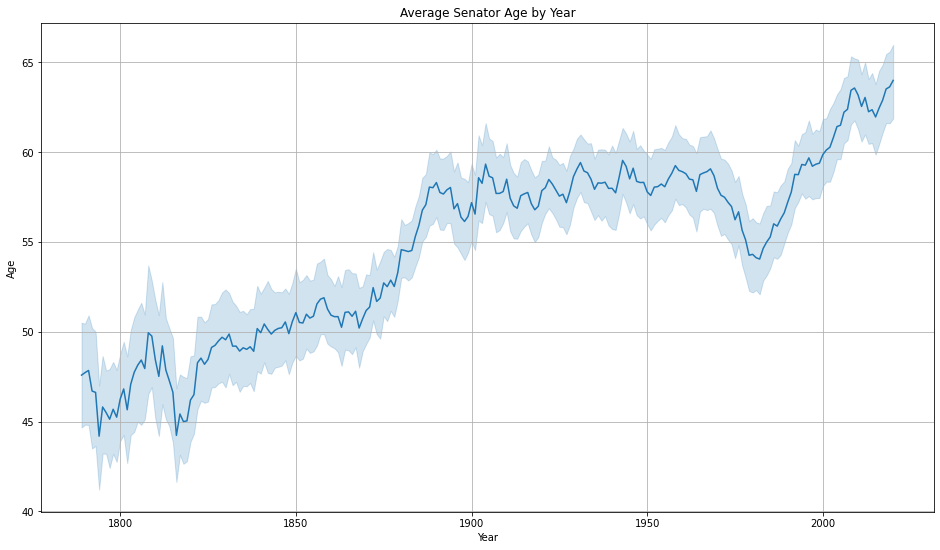

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = senators['Year'], y = senators['Age'])
plt.title("Average Senator Age by Year");
plt.grid()
plt.show()

In [23]:
senators.groupby('Year')['Age'].mean()

Year
1789    47.583333
1790    47.724138
1791    47.843750
1792    46.700000
1793    46.621622
          ...    
2016    62.444444
2017    62.878505
2018    63.504854
2019    63.620370
2020    63.980198
Name: Age, Length: 232, dtype: float64

In [18]:
senators.to_csv("senators.csv", index=False)